In [3]:
import os
import gc
import sys
import argparse
import yaml
import time
import shutil

import pandas as pd
import polars as pl


In [16]:
sys.path.append("/kaggle/src/exp")
sys.path.append("/kaggle/src/data")
sys.path.append("/kaggle/src/model")
sys.path.append("/kaggle/src/dss_utils")
# sys.path.append("/kaggle/src/submission")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from dss_dataloader import get_loader
from dss_model import get_model
from training_loop import concat_valid_input_info, get_valid_values_dict, seed_everything


In [5]:
# exp_dir = "/kaggle/input/dss-exps"
exp_dir = "/kaggle/working"
exp_name = "exp020_dense_chh_skffold_epoch30" # exp020_dense_chh_skffold_epoch30からbest modelを保存するようになった
# series_df_path = "/kaggle/input/dss-train-someunique-series/train_series.parquet"
series_df_path = "/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet"
config_path = os.path.join(exp_dir, exp_name, "config.yaml")

tmp_file_path = "/kaggle/working/tmp"
os.makedirs(tmp_file_path, exist_ok=True)

class_pred_roll_mean_num = 11
class_pred_maxpool_num = 3

dataframe_split_num = 10


# preprocess

In [6]:
def pl_datetime_preprocess(train_series_):
    train_series_ = train_series_.with_columns(
        pl.col("timestamp").str.to_datetime().dt.replace_time_zone(None))
    train_series_ = train_series_.with_columns(
        pl.col("timestamp").dt.second().cast(pl.Int32).alias("second"))
    train_series_ = train_series_.with_columns(
        pl.col("timestamp").dt.minute().cast(pl.Int32).alias("minute"))
    train_series_ = train_series_.with_columns(
        pl.col("timestamp").dt.date().cast(str).alias("date"))
    return train_series_


def preprocess_input(train_series_: pd.DataFrame) -> pd.DataFrame:
    train_series_ = train_series_.drop(columns=["timestamp"], axis=1)
    # anglezとenmoのrolling meanとrolling stdを取る
    print("get anglez and enmo rolling mean and std")
    for roll_num in [36, 60]:  # 雰囲気で選んだ
        train_series_[f"anglez_mean_{roll_num}"] = (
            train_series_.groupby("series_id")["anglez"].rolling(
                roll_num, center=True).mean().reset_index(0, drop=True))
        train_series_[f"anglez_std_{roll_num}"] = (
            train_series_.groupby("series_id")["anglez"].rolling(
                roll_num, center=True).std().reset_index(0, drop=True))
        train_series_[f"anglez_mean_{roll_num}"] = train_series_[
            f"anglez_mean_{roll_num}"].fillna(0)
        train_series_[f"anglez_std_{roll_num}"] = train_series_[
            f"anglez_std_{roll_num}"].fillna(0)    
    return train_series_


def set_seriesdatekey(train_series_: pd.DataFrame) -> pd.DataFrame:
    train_series_["series_date_key"] = (
        train_series_["series_id"].astype(str) + "_" + train_series_["date"].astype(str)
    )
    return train_series_

def label_encode_series_date_key(train_series_: pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    train_series_["series_date_key_str"] = train_series_["series_date_key"].astype(str)
    train_series_["series_date_key"] = le.fit_transform(
        train_series_["series_date_key_str"]
    )
    train_series_["series_date_key"] = train_series_["series_date_key"].astype("int64")
    return train_series_


# post process

In [7]:
# 1step 0.5secで30minなら60*30=1800step?
# metric的にいっぱい検出してもいい？とりあえず小さめ
def detect_event_from_downsample_classpred(df,
                                           N=class_pred_roll_mean_num,
                                           maxpool_kernel_size=class_pred_maxpool_num,
                                           maxpool_stride=1
                                           ):
    df = df[df["second"] == 0].reset_index(drop=True)
    df = df.sort_values(["series_id", "step"]).reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(
        lambda x: x.rolling(N, min_periods=1).mean()
    ).reset_index(drop=True)
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(
        lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1]
    ).reset_index(drop=True)

    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size,
                               stride=maxpool_stride,
                               padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df["onset_pred"] = np.clip(-df["event_pred"], 0, 1)
    df["wakeup_pred"] = np.clip(df["event_pred"], 0, 1)
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


def make_submission_df(df, threshold=0.01):
    df = df[["series_id", "step", "event_pred"]]
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(
        lambda x: 1 if x > threshold else -1 if x < -threshold else 0
    )
    df = df[df["event"] != 0]
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


# infer

In [10]:
pred_df = pd.DataFrame()
for i in range(dataframe_split_num):
    pred_df_tmp = pd.read_csv(os.path.join(tmp_file_path, f"pred_df_split_{i}.csv"))
    pred_df = pd.concat([pred_df, pred_df_tmp], axis=0)


In [14]:
oof_df = pd.DataFrame()
for i in range(5):
    oof_df_tmp = pd.read_parquet(os.path.join(exp_dir, "_oof", exp_name, f"fold{i}_best_oof_df.parquet"))
    oof_df = pd.concat([oof_df, oof_df_tmp], axis=0)


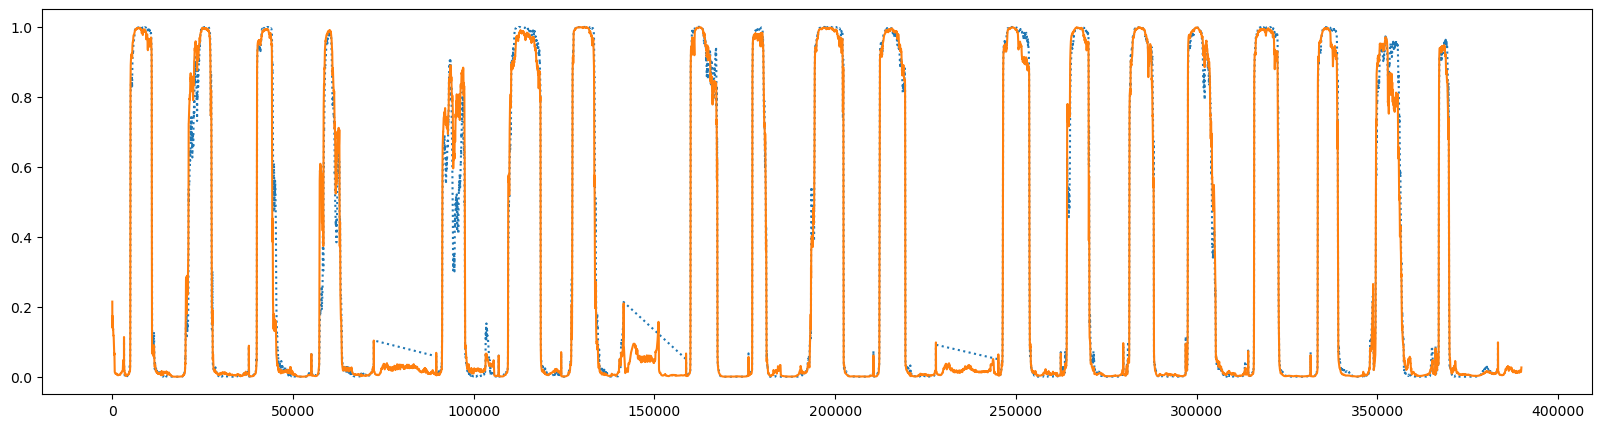

In [22]:
series_id = "038441c925bb"

series_oof = oof_df[oof_df["series_id"] == series_id].reset_index(drop=True)
series_pred = pred_df[pred_df["series_id"] == series_id].reset_index(drop=True)
plt.figure(figsize=(20, 5))
plt.plot(series_oof["step"], series_oof["class_pred"], ":")
plt.plot(series_pred["step"], series_pred["class_pred"])
plt.show()


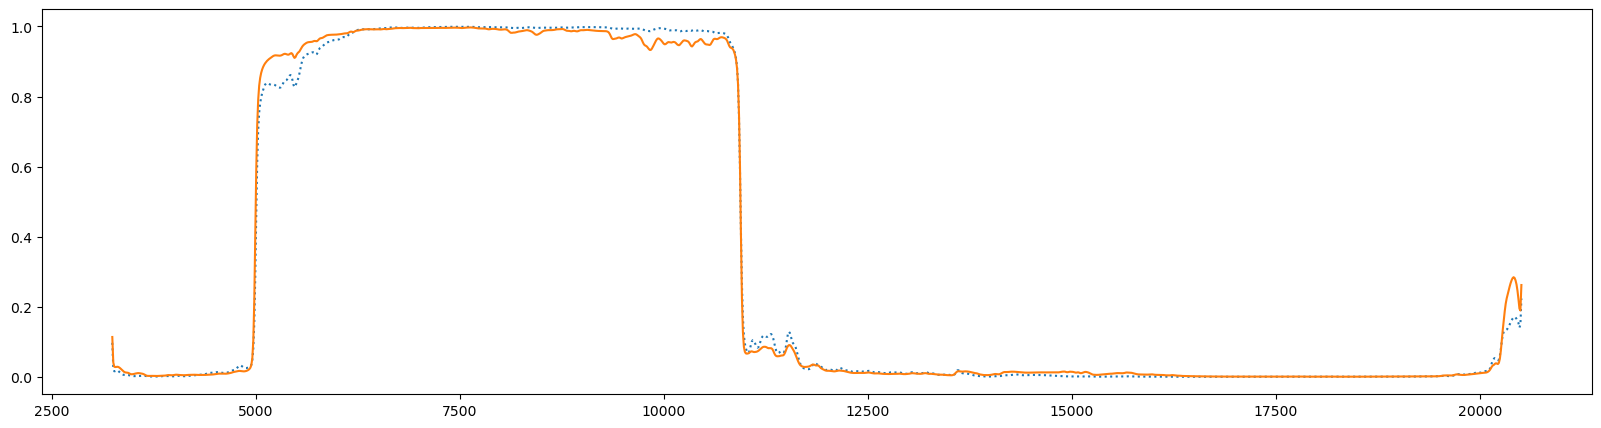

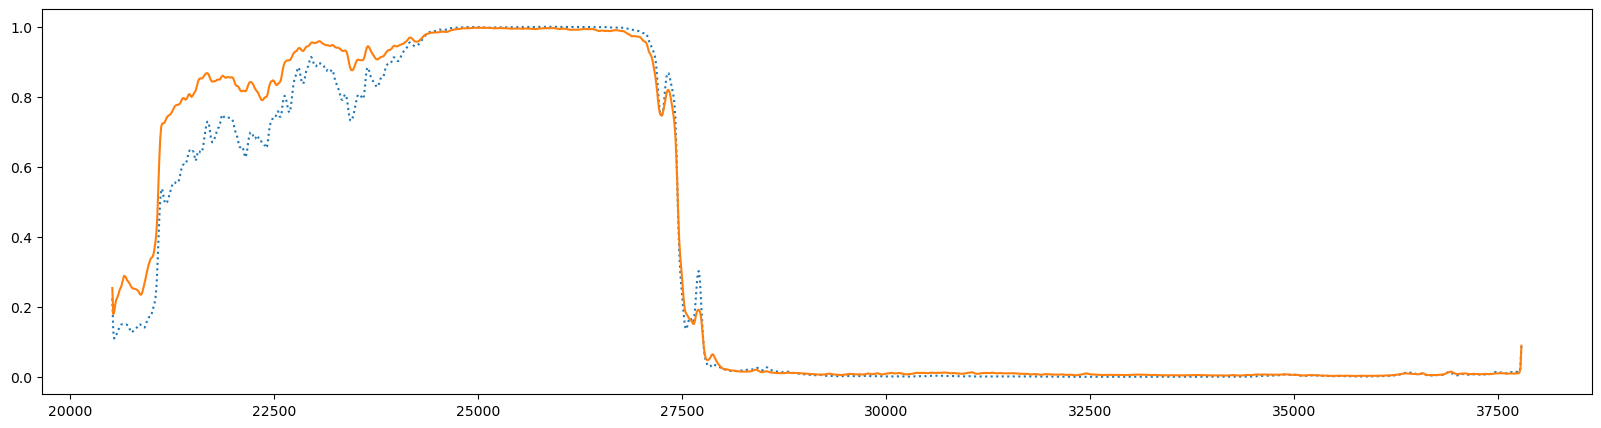

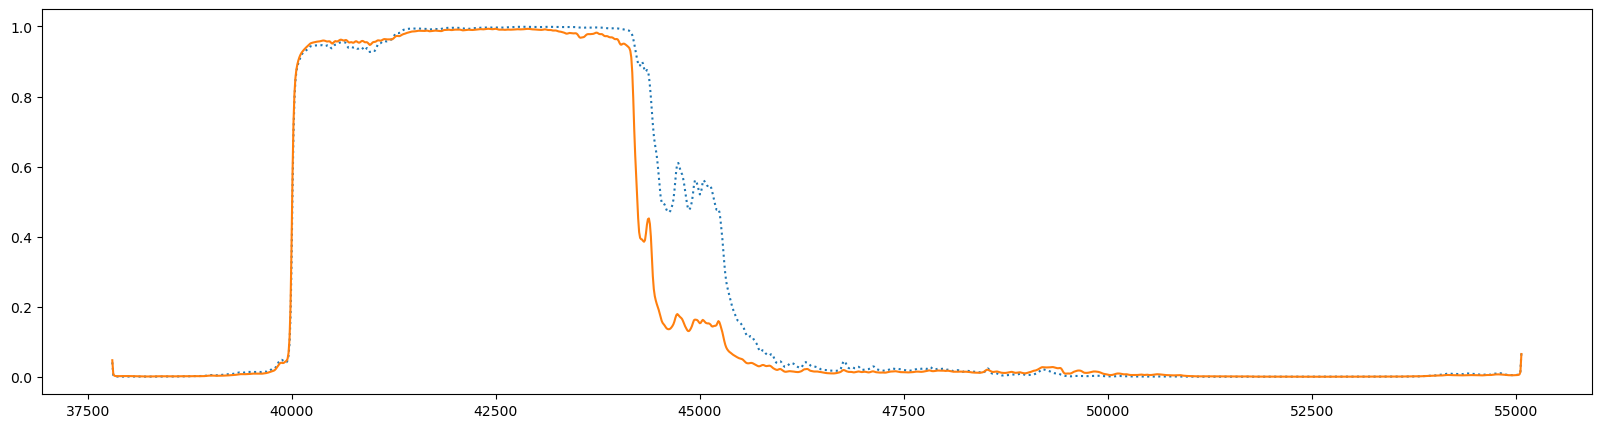

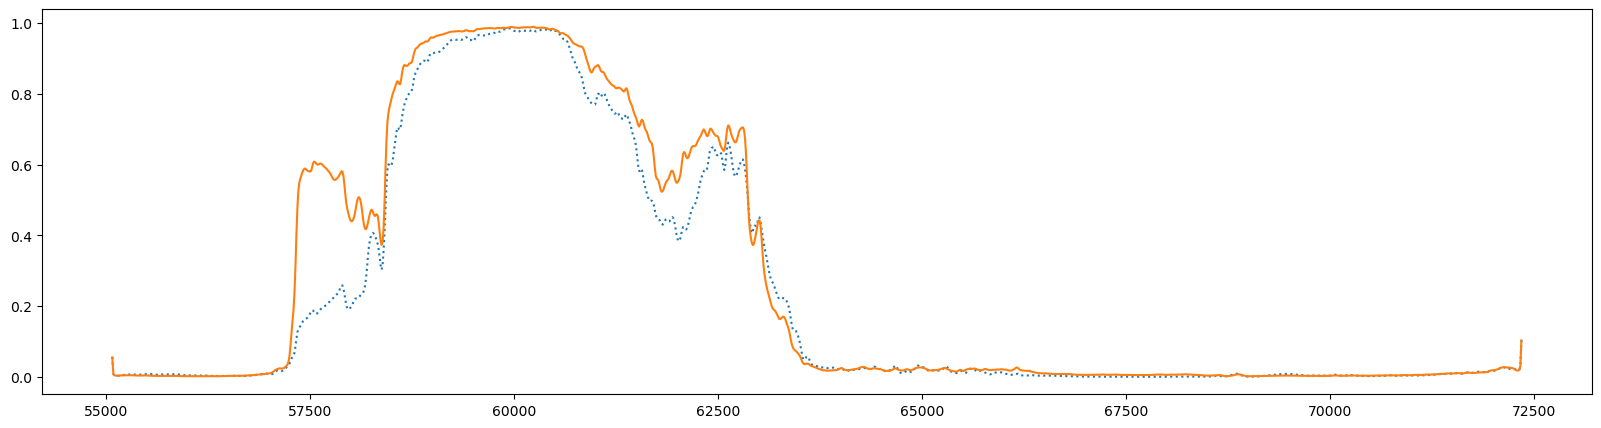

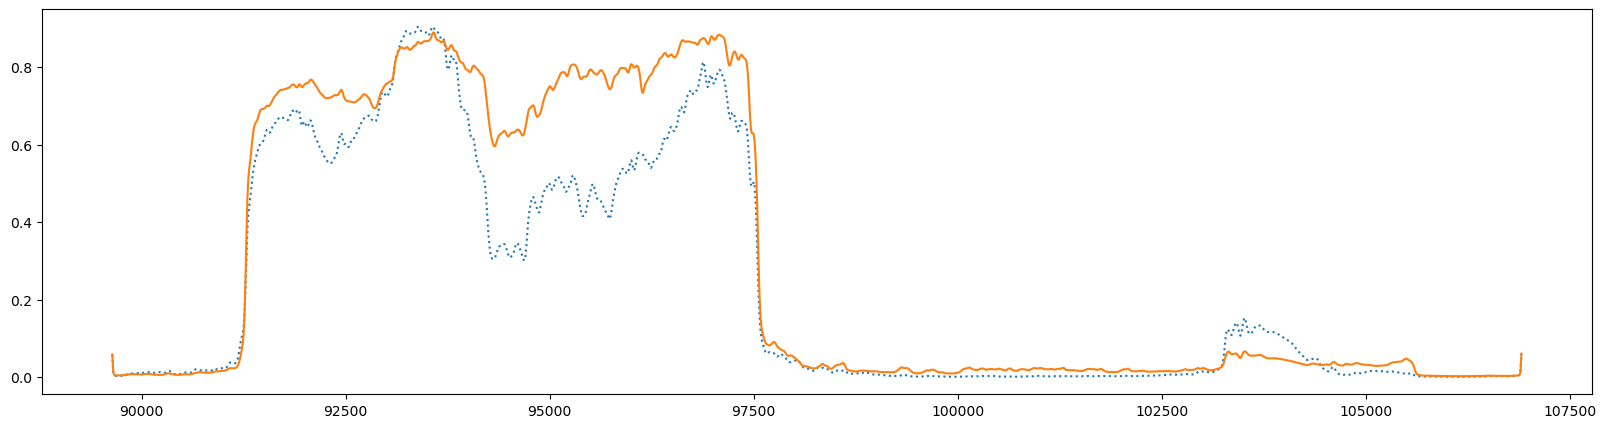

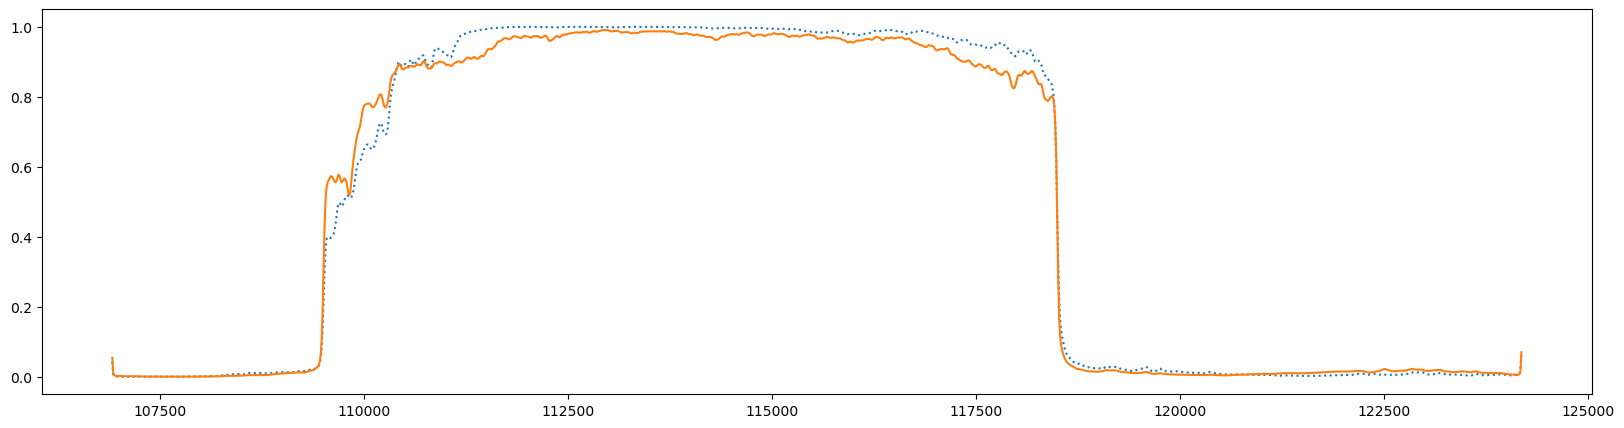

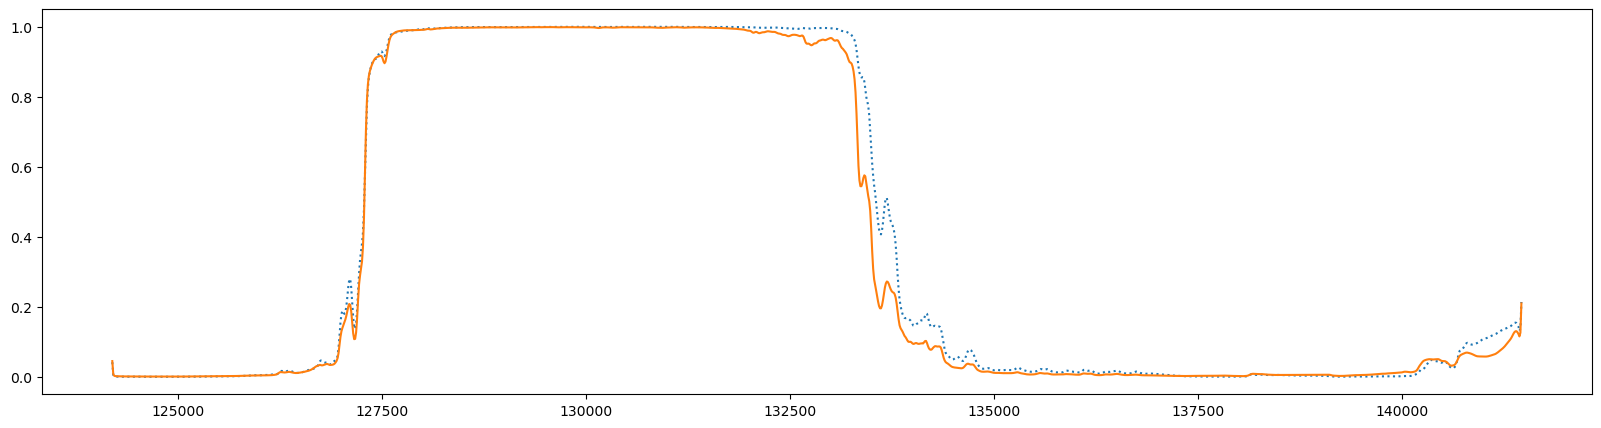

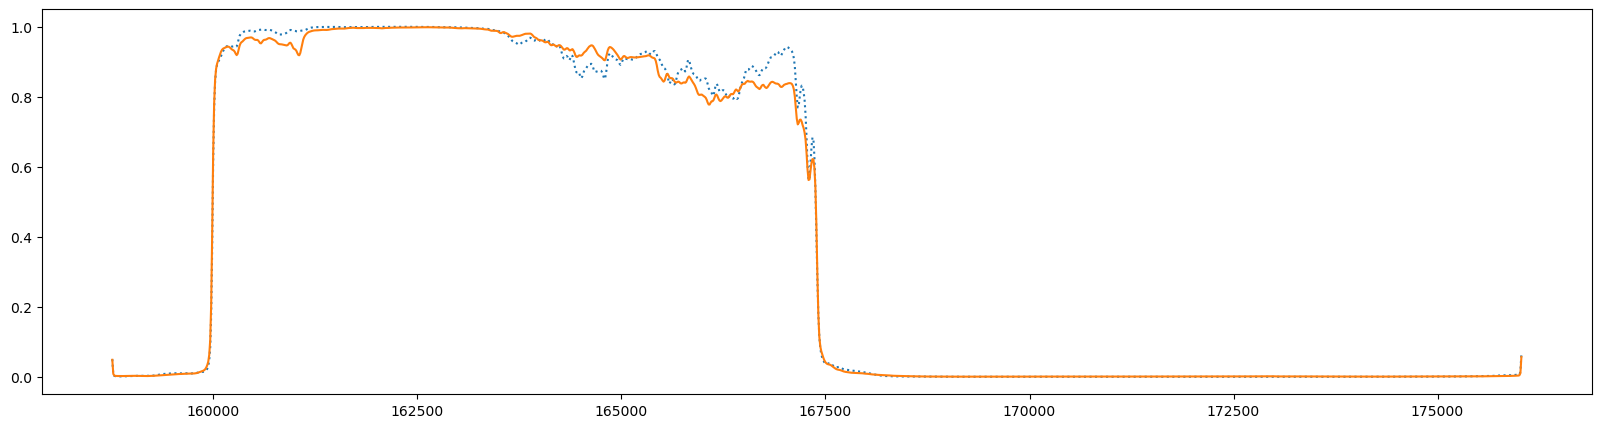

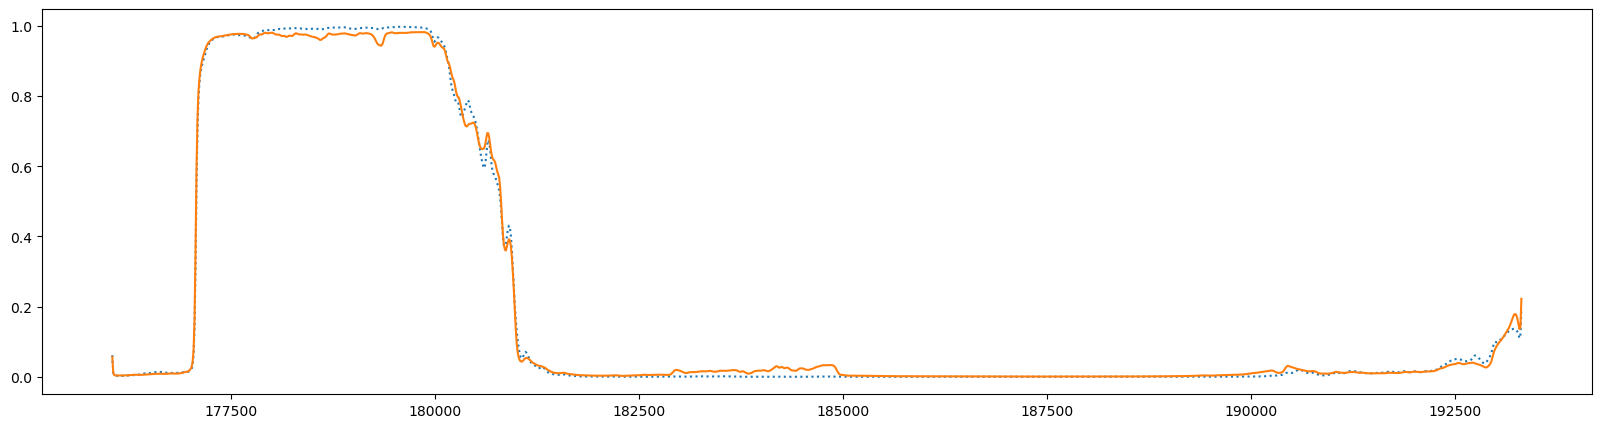

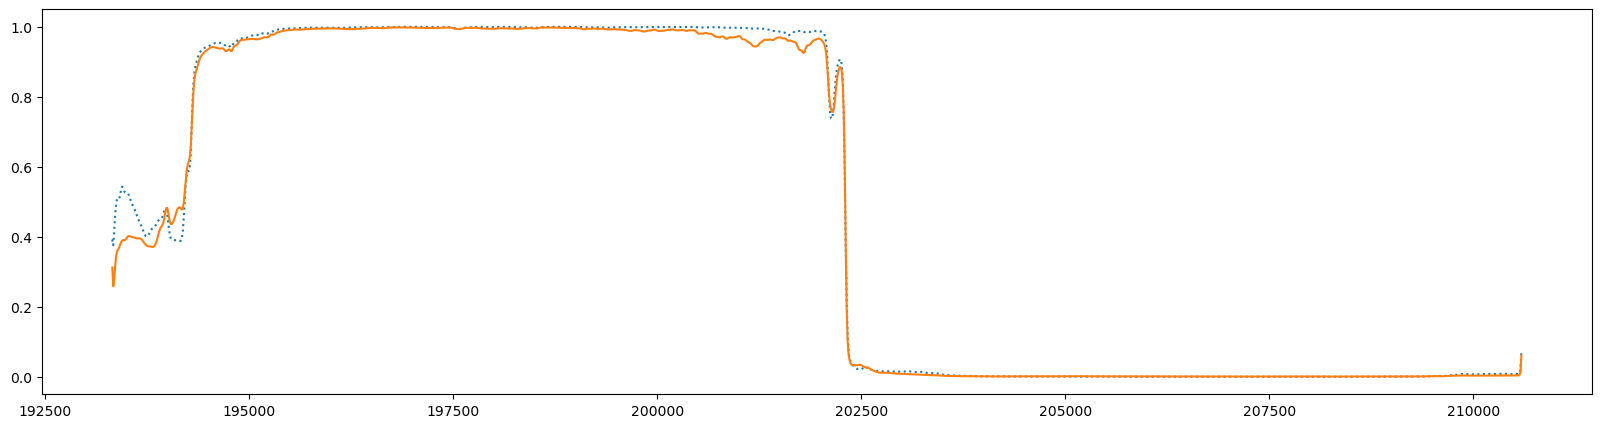

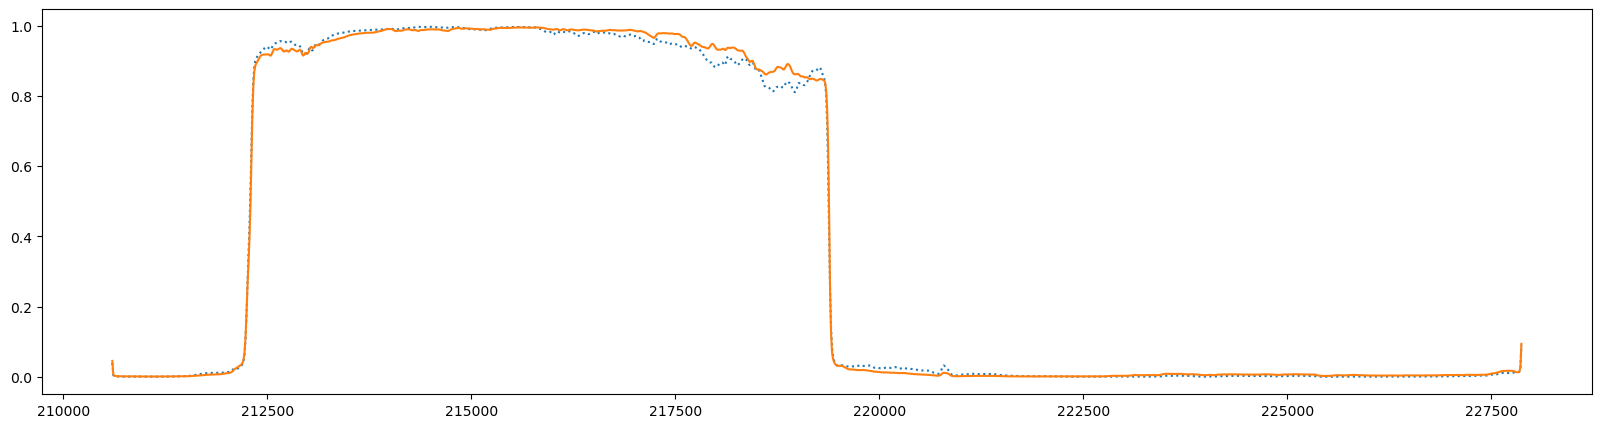

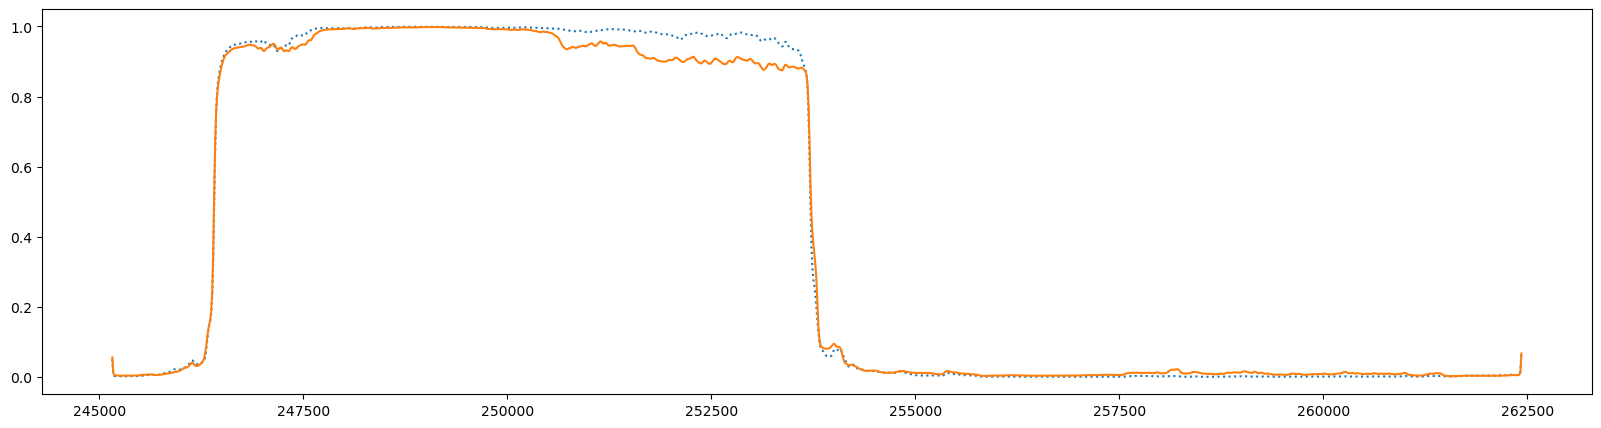

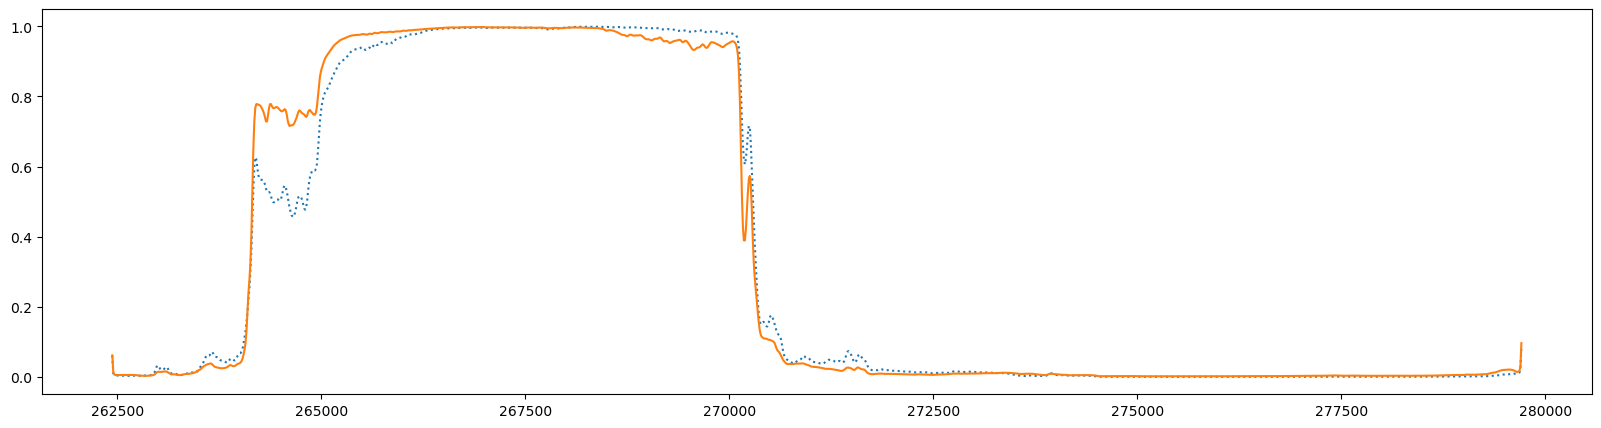

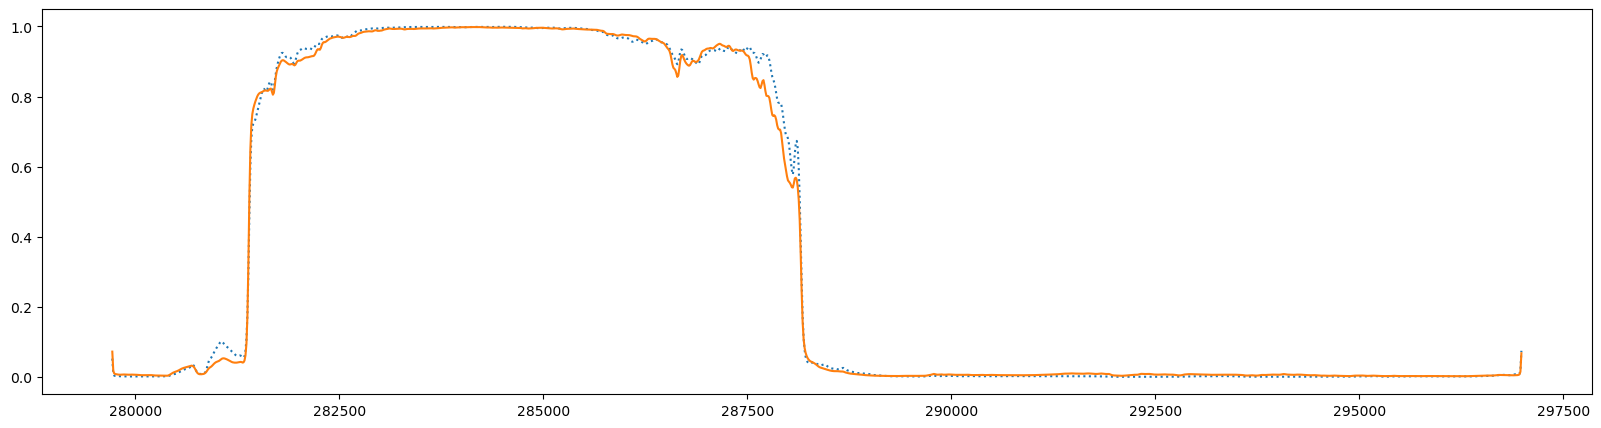

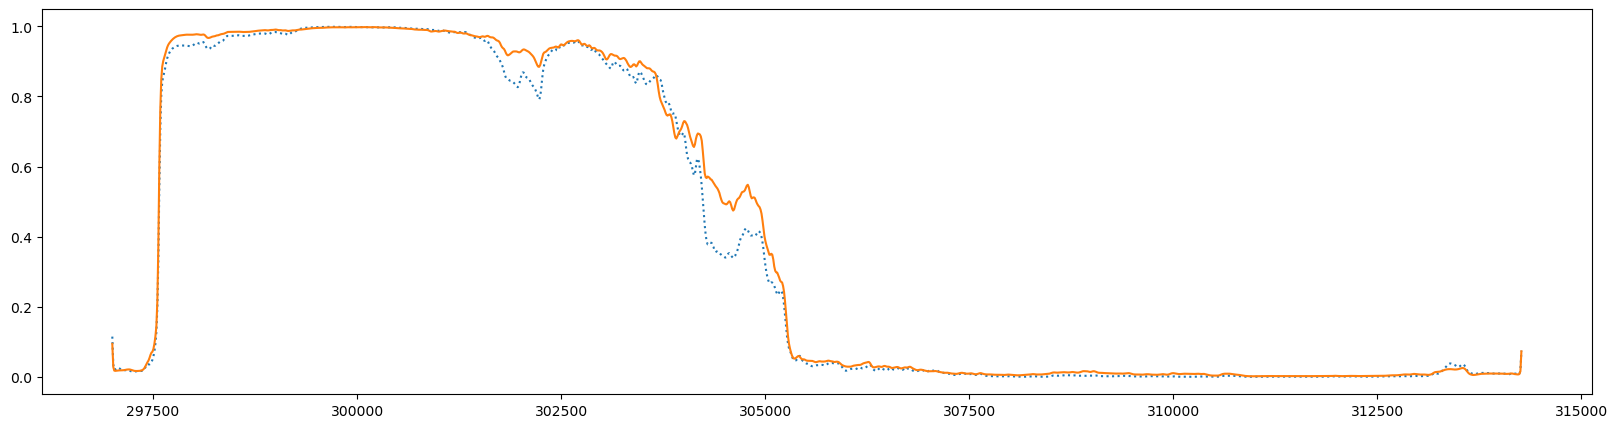

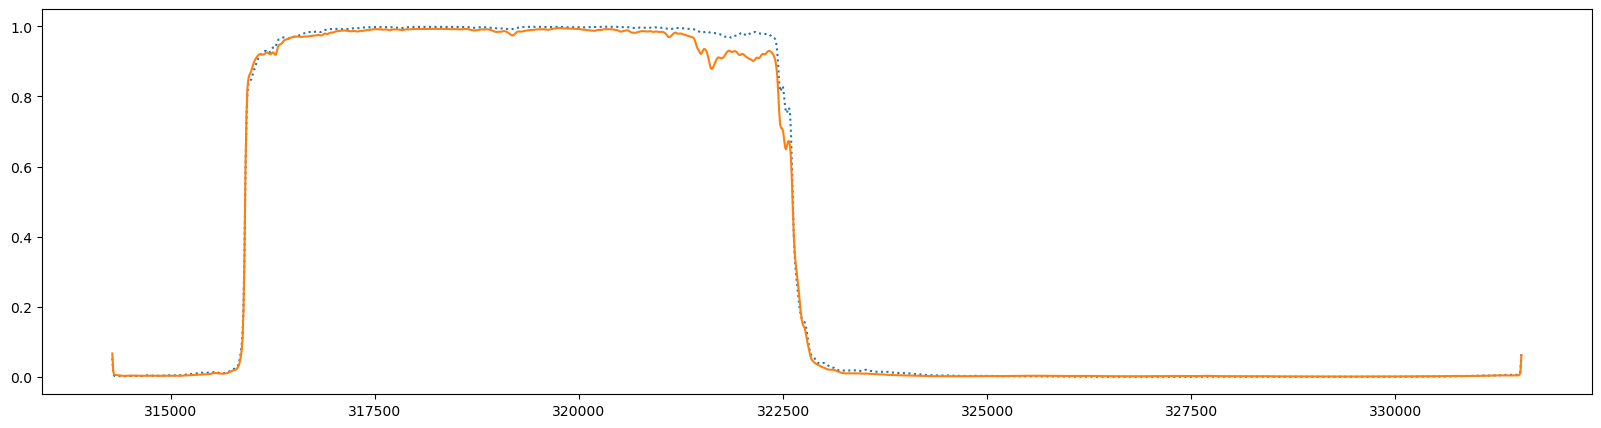

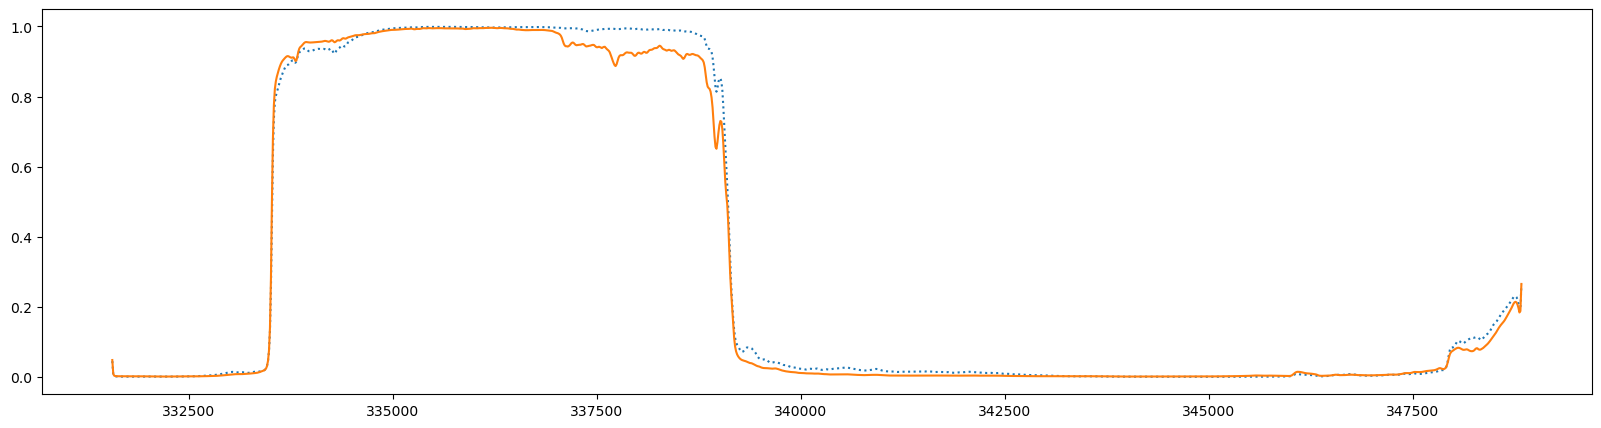

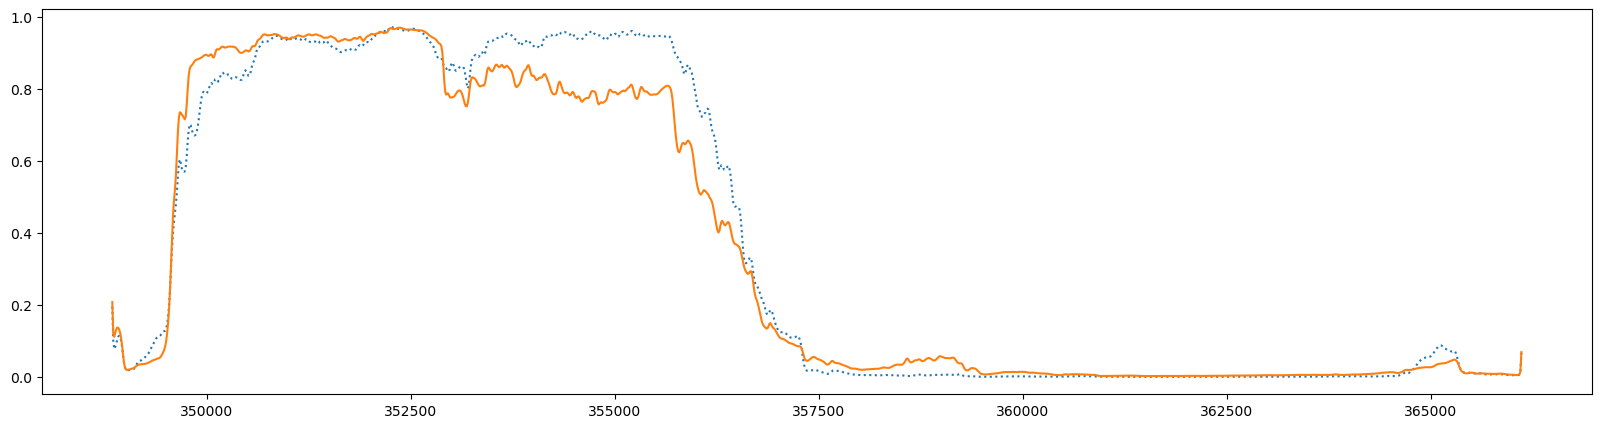

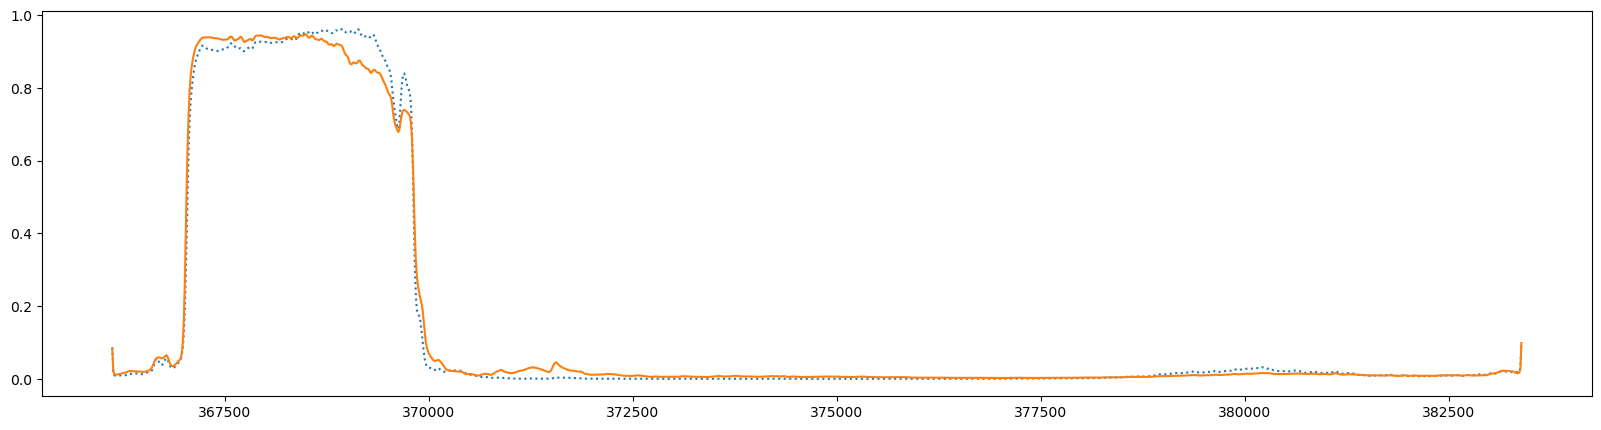

In [21]:
series_id = "038441c925bb"

series_oof = oof_df[oof_df["series_id"] == series_id].reset_index(drop=True)
series_pred = pred_df[pred_df["series_id"] == series_id].reset_index(drop=True)
for key in series_oof["series_date_key"].unique():
    series_oof_tmp = series_oof[series_oof["series_date_key"] == key].reset_index(drop=True)
    start_step = series_oof_tmp["step"].min()
    end_step = series_oof_tmp["step"].max()
    pred_df_tmp = series_pred[(series_pred["step"] >= start_step) & (series_pred["step"] <= end_step)].reset_index(drop=True)
    plt.figure(figsize=(20, 5))
    plt.plot(series_oof_tmp["step"], series_oof_tmp["class_pred"], ":")
    plt.plot(pred_df_tmp["step"], pred_df_tmp["class_pred"])
    plt.show()
